# Принятие решений в бизнесе #

В нашем распоряжении три датасета. Файл `hypothesis.csv` хранит данные о гипотезах для проверки, `orders.csv` — информацию о заказах пользователей и их принадлежность к A/B группе, а `visitors.csv` — информацию о количествах пользователей по A/B группам в зависимости от дня.

**Задача, которую мы пытаемся решить в данном исследовании, следующая:** выбрать подходящую для гипотезу для проведения А/В-теста и провести его.

**Цели исследования:**

1. Приоритизировать гипотезы;
2. Запустить А/В-тест;
3. Проанализировать результаты А/В-теста.

**Ход исследования:**

Мы приступим с загрузки файлов, обозначенных выше, изучим их и проведем преобработку, приведя все данные к стандартному виду, после чего проведём исследование для приоритизации гипотез, и после этого проведём А/В-тест.

**Шаг 1: загрузка и предварительное изучение данных файлов**

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as stats
import datetime as dt
import numpy as np

In [2]:
hp = pd.read_csv('/datasets/hypothesis.csv')
hp.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


In [3]:
hp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Все данные соответствуют своему типу. Необходимо привести наименование столбцов к нижнему регистру. Пропусков не обнаружено.

In [4]:
orders = pd.read_csv('/datasets/orders.csv')
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Столбец date необходимо привести к типу даты, наименования столбцов transactionId и visitorId необходимо привести к стандартному виду. Дубликатов не обнаружено.

In [6]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [7]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Столбец date необходимо привести к типу даты. Дубликатов не обнаружено.

Приведем данные в датасетах orders и hp к нижнему регистру, переименуем некоторые столбцы датасета orders и приведем данные о датах к нужному типу в датасетах orders и visitors.

In [8]:
orders.columns = [x.lower() for x in orders.columns.values]
hp.columns = [x.lower() for x in hp.columns.values]
orders.rename(columns = {'transactionid':'transaction_id', 'visitorid':'visitor_id'}, inplace = True )
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

**Шаг 2: приоритизация гипотез**

Применим фреймворк ICE для приоритизации гипотез

In [9]:
hp['ICE'] = round((hp['impact']*hp['confidence']) / hp['efforts'], 2)
pd.options.display.max_colwidth = 110
print(hp[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

                                                                                                     hypothesis  \
8                                                       Запустить акцию, дающую скидку на товар в день рождения   
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
7              Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
5                      Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользоват

По методу ICE мы выяснили, что в первую очередь стоит браться за проверку гипотезы под номером 8: Запустить акцию, дающую скидку на товар в день рождения.

In [10]:
hp['RICE'] = round((hp['impact']*hp['confidence']*hp['reach']) / hp['efforts'], 2)
pd.options.display.max_colwidth = 110
print(hp[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

                                                                                                     hypothesis  \
7              Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
8                                                       Запустить акцию, дающую скидку на товар в день рождения   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
5                      Добавить страницу отзывов клиентов о магазине, что позвол

По методу RICE мы выяснили, что в первую очередь стоит браться за проверку гипотезы под номером 7: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок. Так как метод RICE скольких пользователей затронет изменение, которое вы хотите внести, остановиться стоит именно на гипотезе номер 7 и проверять ее.

**Шаг 3: анализ A/B-теста**

Для начала проверим не попадают ли какие-то пользователи в обе группы.

In [11]:
check = orders.groupby('visitor_id').agg({'group':'nunique'}).reset_index()
check[check['group'] > 1].count()

visitor_id    58
group         58
dtype: int64

58 пользователей встречаются в обеих группах. Очистим данные от этих пользователей.

In [12]:
id = check['visitor_id'][check['group'] == 1]
orders = orders[orders['visitor_id'].isin(id)]
print(orders)

      transaction_id  visitor_id       date  revenue group
0         3667963787  3312258926 2019-08-15     1650     B
1         2804400009  3642806036 2019-08-15      730     B
3         3797467345  1196621759 2019-08-15     9759     B
4         2282983706  2322279887 2019-08-15     2308     B
5          182168103   935554773 2019-08-15     2210     B
...              ...         ...        ...      ...   ...
1191      3592955527   608641596 2019-08-14    16490     B
1192      2662137336  3733762160 2019-08-14     6490     B
1193      2203539145   370388673 2019-08-14     3190     A
1194      1807773912   573423106 2019-08-14    10550     A
1196      3936777065  2108080724 2019-08-15   202740     B

[1016 rows x 5 columns]


Чтобы построить графики, нужно собрать кумулятивные данные. Объявим датафрейм `cumulativeData`.

In [13]:
datesGroups = orders[['date','group']].drop_duplicates()
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

datesGroups = orders[['date','group']].drop_duplicates()


ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])


cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

1. Построим график кумулятивной выручки по группам. 

Для этого выделим датафреймы `cumulativeRevenueA` и `cumulativeRevenueВ`.

Text(0, 0.5, 'Выручка')

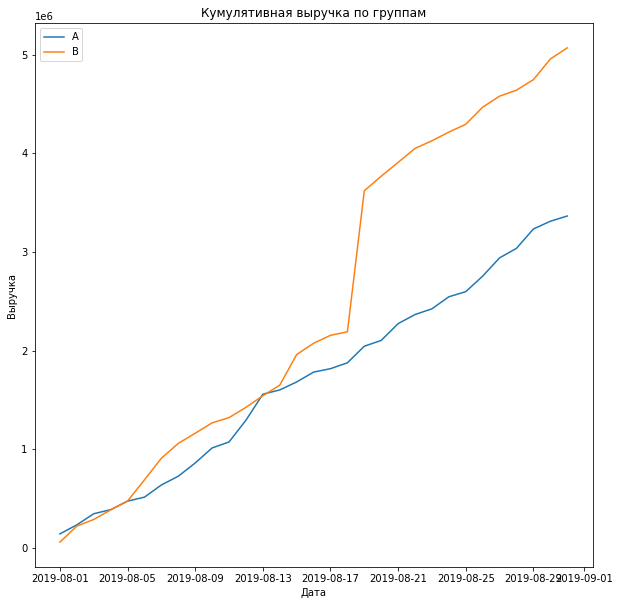

In [14]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(10, 10))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend()
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')

Кумулятивная выручка группы В практически на всем протяжении исследования превышала кумулятивную выручку группы А. Однако 21 августа 2019 года имеется выброс в выручке группы В – возможно, в этот день пользователем была совершена крупная покупка, повлиявшая на общие данные.

2. Построим график кумулятивного среднего чека по группам. 

Text(0, 0.5, 'Средний чек')

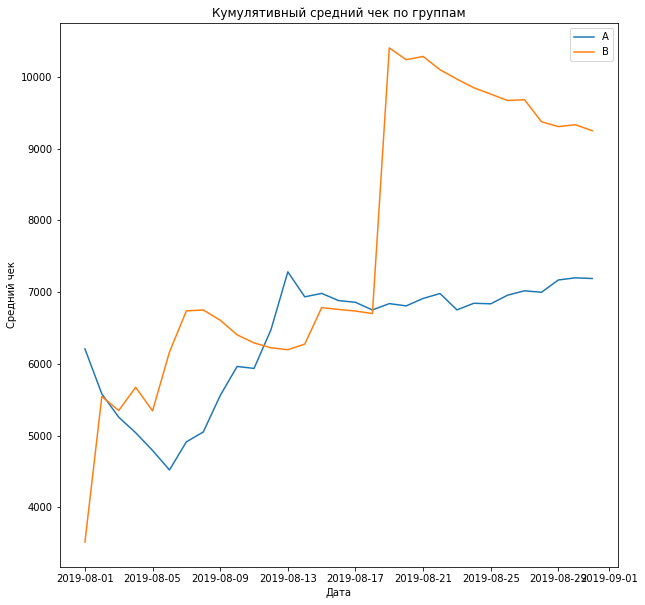

In [15]:
plt.figure(figsize=(10, 10))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend() 
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')

Кумулятивный средний чек группы В практически на всем протяжении исследования превышал средний чек группы А, однако с 1 сентября пошел на спад. Однако, 21 августа 2019 года средний чек резко увеличился с приблизительно 6500 до более чем 10000. Возможно, такой выброс был вызван крупной покупкой пользователя или ошибкой в данных.

3. Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

Text(0, 0.5, 'Относительное изменение')

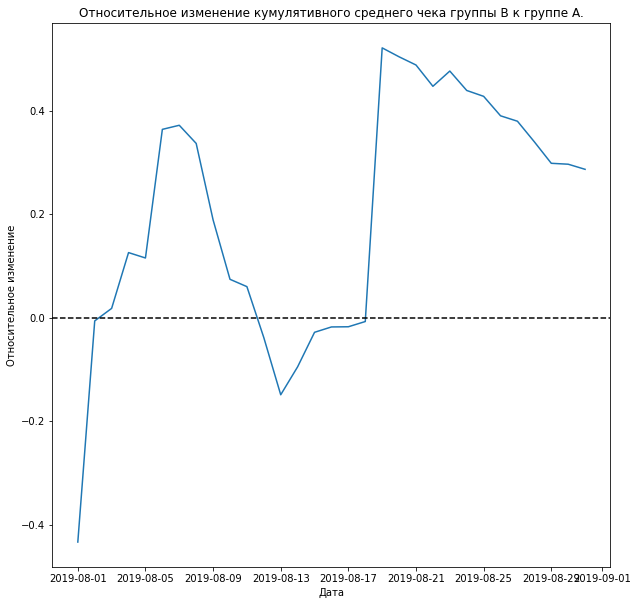

In [16]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(10, 10))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='--') 
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A.')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')

Относительного изменение кумулятивного среднего чека группы B к группе A было положительным практически во все время исследования. Отрицательные значения наблюдаются лишь в промежутке от 10 до 13 августа 2019 года – стоит обратить особо внимание на причины, вызвавшие это.

4. Построим график кумулятивного среднего количества заказов на посетителя по группам.

Text(0, 0.5, 'Среднее количество заказов')

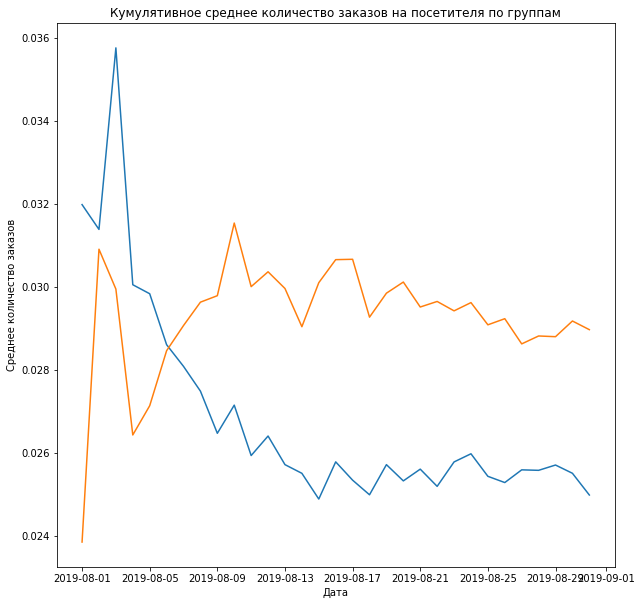

In [17]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(10, 10))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('Кумулятивное среднее количество заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов')

Поситетели из группы А совершали преимущественно большее количество заказов в среднем, чем пользователи группы В вплоть до 6-7 августа 2019 года, после чего среднее количество заказов среди пользователей группы В было большим, чем среди пользователей группы А. 2-3 августа 2019 года наблюдается резкий скачок в среднем количестве заказов у обоих группах. В дальнейшем стоит обратить на это внимание и выяснить, что послужило причиной этому.

5. Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

Text(0, 0.5, 'Относительное изменение')

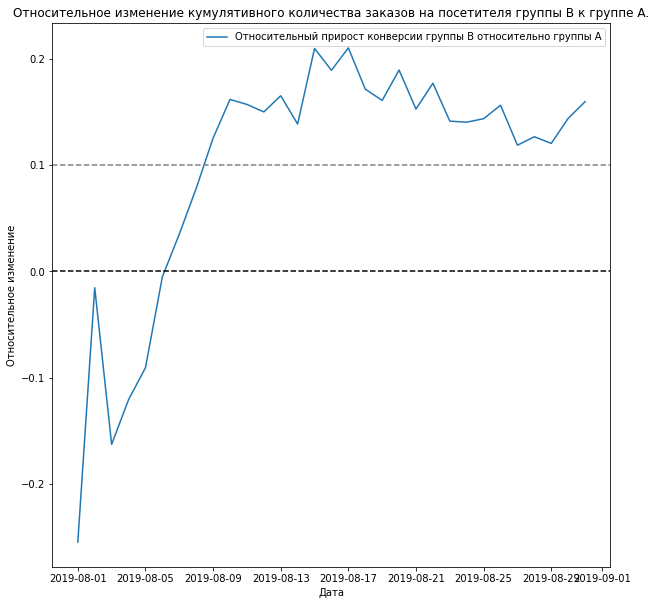

In [19]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(10, 10))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y = 0.1, color='grey', linestyle='--');
plt.title('Относительное изменение кумулятивного количества заказов на посетителя группы B к группе A.')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')

Относительного изменение кумулятивного среднего количества заказов на посетителя группы B к группе A преимущественно после 6-7 августа 2019 года стало положительным и наблюдается относительно стабильная динамика. По этому графику мы также можем наблюдать выброс в промежутке от 2 до 4 августа 2019 года – стоит в дальнейшем разобраться в причинах, вызванных этим.

6. Построим точечный график количества заказов по пользователям.

Text(0, 0.5, 'Пользователи')

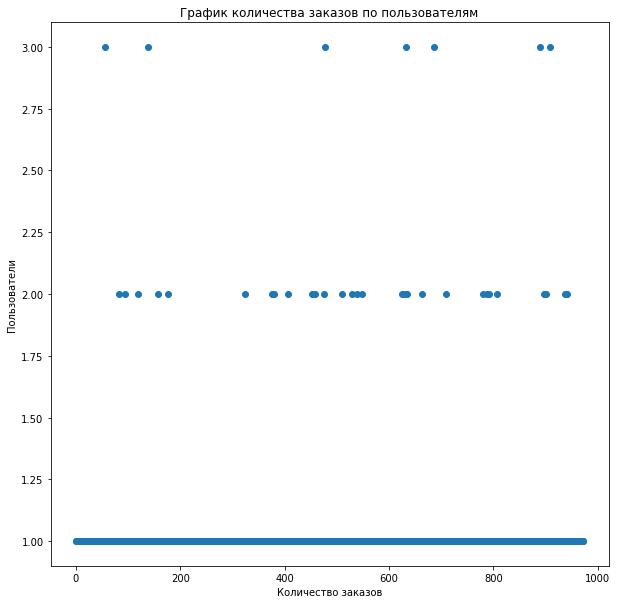

In [20]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['visitor_id', 'orders']

x_values = pd.Series(range(0, len(ordersByUsers)))
plt.figure(figsize=(10, 10))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('График количества заказов по пользователям')
plt.xlabel('Количество заказов')
plt.ylabel('Пользователи')

Большая часть пользователей не совершила лишь один заказ. Преимущественно пользователи совершали около 2 заказов – пользователей, совершивших более 4 заказов не обнаружено.

7. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [21]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[1. 2.]


Не более 5% пользователей совершают более 1 покупок и не более 1% пользователей совершают более 2 покупок.
Следовательно, определим границу определения аномалий в 2 покупки.

In [22]:
border_quantaty = 2

8. Построим точечный график стоимостей заказов. 

Text(0, 0.5, 'Стоимость заказов')

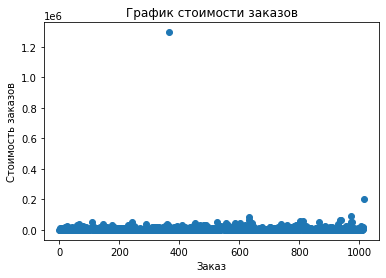

In [23]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('График стоимости заказов')
plt.xlabel('Заказ')
plt.ylabel('Стоимость заказов')

Большая часть заказов не превышает по стоимости 200000 и вариируется около 0. Однако, по графику мы можем наблюдать покупку, которая значительно превышает все остальные – более 12000000.

9. Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [24]:
print(np.percentile(orders['revenue'], [95, 99])) 

[26785. 53904.]


Не более 5% заказов дороже 26785 и не более 1% заказов дороже 53904.

Определим границу аномалий в 27000.

In [25]:
border_price = 27000

10. Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Для этого сформуруем две гипотезы, которые будем проверять:

Н0 – статистически значимых различий в среднем числе заказов между группами нет

Н1 – статистически значимые различия в среднем числе заказов между группами присутствуют

In [26]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)


ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]), ': уровень статистической значимости')

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1), ': относительные различия в среднем числе заказов между группами')

0.011 : уровень статистической значимости
0.160 : относительные различия в среднем числе заказов между группами


По «сырым» данным различия в среднем числе заказов групп A и B есть. 
Первое число — p-value = 0.011 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем.

11. Посчитам статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 

Для определения различий в среднем чеке сформуруем две гипотезы:

Н0 – в среднем чеке заказа между группами отсутствуют различия 

Н1 – в среднем чеке заказа между группа присутствуют различия

In [27]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.829
0.287


P-value 0.829 больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.

12. Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

Для проверки статистической значимости снова сформулируем две гипотезы:

Н0 – статистически значимых различий в среднем числе заказов между группами нет

Н1 – статистически значимые различия в среднем числе заказов между группами присутствуют

In [28]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > border_quantaty]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > border_quantaty]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > border_price]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.012
0.182


Результаты по среднему количеству заказов не изменились, p-value остался на прежнем уровне – менее 0.05 (0.012). Оснований принять нулевую гипотезу нет.

13. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Для проверки статистической значимости снова сформулируем две гипотезы:

Н0 – в среднем чеке заказа между группами отсутствуют различия
Н1 – в среднем чеке заказа между группа присутствуют различия

In [29]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.646
-0.048


P-value не изменился в сравнении с сырыми данными и все еще больше 0.05: 0.646. Оснований отвергнуть нулевую гипотезу нет.

# Выводы #

**На основе полученных нами данных мы провели исследование и выполнили следующие задачи:**

1. Приоритизировали гипотезы.
2. Выявили самую подходящую для проверки гипотезу.
3. Провели А/В-тест, на основе которого сделали выводы.

**Проанализировав данные, можно сделать следующие выводы:**

1. Кумулятивная выручка группы В практически на всем протяжении исследования превышала кумулятивную выручку группы А. Однако 21 августа 2019 года имеется выброс в выручке группы В – возможно, в этот день пользователем была совершена крупная покупка, повлиявшая на общие данные.
2. Кумулятивный средний чек группы В практически на всем протяжении исследования превышал средний чек группы А, однако с 1 сентября пошел на спад. Однако, 21 августа 2019 года средний чек резко увеличился с приблизительно 6500 до более чем 10000. Возможно, такой выброс был вызван крупной покупкой пользователя или ошибкой в данных.
3. Относительного изменение кумулятивного среднего чека группы B к группе A было положительным практически во все время исследования. Отрицательные значения наблюдаются лишь в промежутке от 10 до 13 августа 2019 года – стоит обратить особо внимание на причины, вызвавшие это.
4. Поситетели из группы А совершали преимущественно большее количество заказов в среднем, чем пользователи группы В вплоть до 6-7 августа 2019 года, после чего среднее количество заказов среди пользователей группы В было большим, чем среди пользователей группы А. 2-3 августа 2019 года наблюдается резкий скачок в среднем количестве заказов у обоих группах. В дальнейшем стоит обратить на это внимание и выяснить, что послужило причиной этому.
4. Большая часть пользователей совершила лишь один заказ. Преимущественно пользователи совершали около 2 заказов – пользователей, совершивших более 4 заказов не обнаружено.
5. Не более 5% пользователей совершают более 1 покупок и не более 1% пользователей совершают более 2 покупок. Следовательно, определим границу определения аномалий в 1 покупку.
6. Большая часть заказов не превышает по стоимости 200000 и вариируется около 0. Однако, по графику мы можем наблюдать покупку, которая значительно превышает все остальные – более 12000000.
7. Не более 5% заказов дороже 26785 и не более 1% заказов дороже 53904.
8. Статистически значимые различия в среднем числе заказов по как «сырым», так и очищенным данным между группами присутствуют
9. В среднем чеке заказа о как «сырым», так и очищенным данным между группами отсутствуют различия

Исходя из обнаруженных фактов, тест следует остановить и признать его неуспешным. Продолжать смысла нет, потому как вероятность, что при имеющихся данных сегмент B на самом деле лучше сегмента A — практически нулевая.